<a href="https://colab.research.google.com/github/AmoguJUduka/MachineLearning/blob/main/DeepLearningAssignments/BasicLSTM_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW4 Assignment Goals

1. Understand the core concepts of the Transfomrer Architecture
2. Application to Sequence-to-Sequence Tasks
3. Impact of Hyperparameters


LSTM is a structure that can be usedin neural network. It is a type of RNN that expects the input in the form of sequences of features. It is useful for data such as time series or string of text.

Install necessary packages

In [1]:
!pip uninstall torch -y
!pip install torch==2.2.0+cu118 torchvision==0.15.2+cu118 torchaudio==2.2.0+cu118 --index-url https://download.pytorch.org/whl/cu118
!pip install evaluate
!pip install datasets
!pip uninstall torchtext -y
!pip install torchtext==0.17.0

Found existing installation: torch 2.2.0
Uninstalling torch-2.2.0:
  Successfully uninstalled torch-2.2.0
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.2.0%2Bcu118-cp310-cp310-linux_x86_64.whl (811.7 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.15.2%2Bcu118-cp310-cp310-linux_x86_64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.2.0%2Bcu118-cp310-cp310-linux_x86_64.whl (3.3 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_nvrtc_cu11-11.8.89-py3-none-manylinux1_x86_64.whl (23.2 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_runtime_cu11-11.8.89-py3-none-manylinux1_x86_64.whl (875 kB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_cupti_cu11-11.8.87-py3-none-manylinux1_x86_64.whl (13.1 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cudnn_cu11-8.7.0.84-py3-none-manylinux1_x86_6

import necessary packages

In [2]:
import torchtext
import datasets
import torch
import torch.nn as nn
import random
import torch.optim as optim
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive

**Problem 1**

In [3]:
# Sentences
sentence_en = "No way out but a ruthless commitment to hard work"
sentence_de = "Es gibt keinen Ausweg außer einem rücksichtslosen Einsatz für harte Arbeit"

Download necessary packages

In [4]:
import spacy.cli
spacy.cli.download("en_core_web_sm")  # English pipeline
spacy.cli.download("de_core_news_sm") # German pipeline

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Tokenization of sentences

In [5]:
# English Sentence
en_nlp = spacy.load("en_core_web_sm")
doc = en_nlp(sentence_en)
tokens = [token.text for token in doc]
print(tokens)

['No', 'way', 'out', 'but', 'a', 'ruthless', 'commitment', 'to', 'hard', 'work']


In [6]:
# German Sentence
de_nlp = spacy.load("de_core_news_sm")
doc = de_nlp(sentence_de)
tokens = [token.text for token in doc]
print(tokens)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


['Es', 'gibt', 'keinen', 'Ausweg', 'außer', 'einem', 'rücksichtslosen', 'Einsatz', 'für', 'harte', 'Arbeit']


**Revised Problem 1**

In [7]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

In [8]:
# Example
my_example = {'en': sentence_en, 'de': sentence_de}
tokenize_example(my_example, en_nlp, de_nlp, 1000, True, "<sos>", "<eos>")

{'en_tokens': ['<sos>',
  'no',
  'way',
  'out',
  'but',
  'a',
  'ruthless',
  'commitment',
  'to',
  'hard',
  'work',
  '<eos>'],
 'de_tokens': ['<sos>',
  'es',
  'gibt',
  'keinen',
  'ausweg',
  'außer',
  'einem',
  'rücksichtslosen',
  'einsatz',
  'für',
  'harte',
  'arbeit',
  '<eos>']}

**Problem 2**

Importing the Dataset (Multi-30K)

In [9]:
dataset = datasets.load_dataset("bentrevett/multi30k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

Inspecting size of dataset

In [11]:
train_data.shape

(29000, 2)

In [12]:
valid_data.shape

(1014, 2)

In [13]:
test_data.shape

(1000, 2)

Model Process

In [14]:
max_length = 1000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creation of vocabulary

In [15]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [16]:
assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [17]:
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

Adding ids to vocabulary

In [18]:
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [19]:
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [20]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [21]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch

    return collate_fn

In [22]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

Hyperparameters

1. Batch Size = 128

2. Learning Rate = 0.001

3. Loss Function = Cross Entropy

4. Epochs = 10

5. Optimzer = Adam

In [23]:
seed = 41
import random
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [24]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

Transformer (GRU)

In [25]:
num_layers = 1

class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout, num_layers
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.num_layers = num_layers
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim,num_layers=num_layers, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )

        return outputs, hidden

In [26]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v_fc(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

In [27]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
        num_layers=num_layers
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim, num_layers)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        return prediction, hidden.squeeze(0), a.squeeze(1)

In [28]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):

        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        input = trg[0, :]
        for t in range(1, trg_length):

            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)

            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1

        return outputs

Model 1

In [29]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
    num_layers
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
    num_layers
)

model1 = Seq2Seq(encoder, decoder, device).to(device)

In [30]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model1.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model1):,} trainable parameters")

The model has 20,518,405 trainable parameters


In [32]:
optimizer = optim.Adam(model1.parameters())

In [33]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [34]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [35]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [36]:
import tqdm
import numpy as np

n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
train_losses = []  # List to store training losses for each epoch
valid_losses = []  # List to store validation losses for each epoch
best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    # Get the training loss for the current epoch
    epoch_train_loss = train_fn(
        model1,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    train_losses.append(epoch_train_loss)  # Append current epoch's train loss to the list

    # Get the validation loss for the current epoch
    epoch_valid_loss = evaluate_fn(
        model1,
        valid_data_loader,
        criterion,
        device,
    )
    valid_losses.append(epoch_valid_loss)  # Append current epoch's valid loss to the list

    # Check if the validation loss is the best we've seen so far
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model1.state_dict(), "tut3-model1.pt")

    # Print the training and validation losses for the current epoch
    print(f"\tTrain Loss: {epoch_train_loss:7.3f} | Train PPL: {np.exp(epoch_train_loss):7.3f}")
    print(f"\tValid Loss: {epoch_valid_loss:7.3f} | Valid PPL: {np.exp(epoch_valid_loss):7.3f}")


 10%|█         | 1/10 [01:36<14:27, 96.43s/it]

	Train Loss:   5.007 | Train PPL: 149.457
	Valid Loss:   4.700 | Valid PPL: 109.990


 20%|██        | 2/10 [03:11<12:45, 95.65s/it]

	Train Loss:   4.044 | Train PPL:  57.033
	Valid Loss:   4.144 | Valid PPL:  63.058


 30%|███       | 3/10 [04:46<11:08, 95.53s/it]

	Train Loss:   3.331 | Train PPL:  27.965
	Valid Loss:   3.662 | Valid PPL:  38.937


 40%|████      | 4/10 [06:21<09:30, 95.06s/it]

	Train Loss:   2.813 | Train PPL:  16.660
	Valid Loss:   3.413 | Valid PPL:  30.360


 50%|█████     | 5/10 [07:55<07:53, 94.73s/it]

	Train Loss:   2.436 | Train PPL:  11.426
	Valid Loss:   3.345 | Valid PPL:  28.374


 60%|██████    | 6/10 [09:29<06:17, 94.38s/it]

	Train Loss:   2.172 | Train PPL:   8.780
	Valid Loss:   3.258 | Valid PPL:  26.007


 70%|███████   | 7/10 [11:04<04:43, 94.61s/it]

	Train Loss:   1.919 | Train PPL:   6.817
	Valid Loss:   3.259 | Valid PPL:  26.016


 80%|████████  | 8/10 [12:38<03:09, 94.56s/it]

	Train Loss:   1.716 | Train PPL:   5.560
	Valid Loss:   3.348 | Valid PPL:  28.444


 90%|█████████ | 9/10 [14:12<01:34, 94.42s/it]

	Train Loss:   1.576 | Train PPL:   4.836
	Valid Loss:   3.345 | Valid PPL:  28.374


100%|██████████| 10/10 [15:47<00:00, 94.76s/it]

	Train Loss:   1.472 | Train PPL:   4.360
	Valid Loss:   3.415 | Valid PPL:  30.412


In [37]:
model1.load_state_dict(torch.load("tut3-model1.pt"))

test_loss = evaluate_fn(model1, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 3.258 | Test PPL:  26.002 |


In [38]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=100,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            de_tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            de_tokens = [token for token in sentence]
        if lower:
            de_tokens = [token.lower() for token in de_tokens]
        de_tokens = [sos_token] + de_tokens + [eos_token]
        ids = de_vocab.lookup_indices(de_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, de_tokens, attentions[: len(en_tokens) - 1]

In [39]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

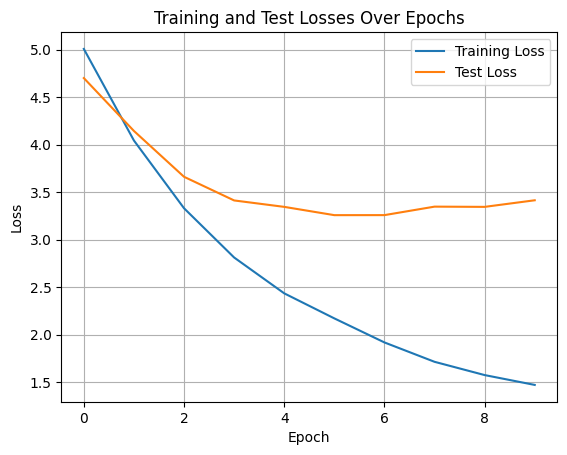

In [40]:
import matplotlib.pyplot as plt

# Plot both training and test losses
plt.plot(range(n_epochs), train_losses, label="Training Loss")
plt.plot(range(n_epochs), valid_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Losses Over Epochs")
plt.grid()
plt.show()

From the plot, the model is effectively learning from the training data, however the gap between the both losses indicates that the model is likely overfitting as it contninues to learn patterns specific to the training data that do not generalize well to new data.

In [41]:
sentence = "Die Ratte rennt durch ein Loch in der Wand"

['<sos>', 'the', '<unk>', 'is', 'is', 'through', 'a', 'hole', 'in', 'the', 'snow', '.', '<eos>']


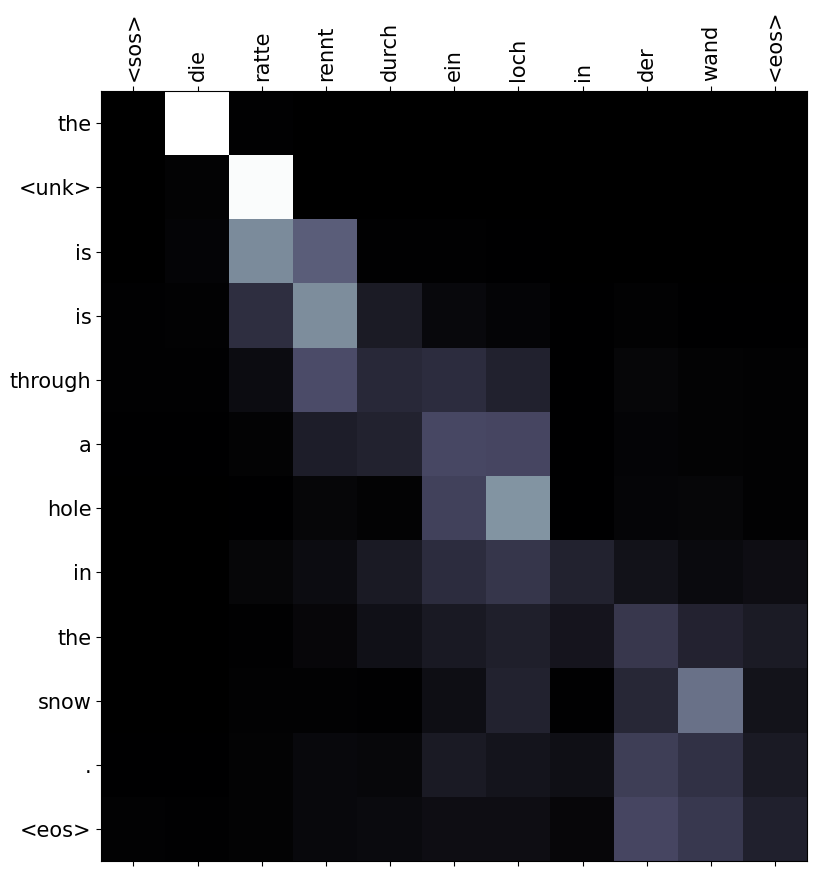

In [42]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model1,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation) #The rat ran through a hole in the wall
plot_attention(sentence_tokens, translation, attention)

Model 2

In [56]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 64
decoder_embedding_dim = 64
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
    num_layers
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
    num_layers
)

model2 = Seq2Seq(encoder, decoder, device).to(device)

In [57]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model2.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 64)
    (rnn): GRU(64, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 64)
    (rnn): GRU(1088, 512)
    (fc_out): Linear(in_features=1600, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [58]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model2):,} trainable parameters")

The model has 15,862,981 trainable parameters


In [59]:
optimizer_ = optim.Adam(model1.parameters())

In [60]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [61]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
train_losses_ = []  # List to store training losses for each epoch
valid_losses_ = []  # List to store validation losses for each epoch
best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    # Get the training loss for the current epoch
    epoch_train_loss = train_fn(
        model2,
        train_data_loader,
        optimizer_,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    train_losses_.append(epoch_train_loss)  # Append current epoch's train loss to the list

    # Get the validation loss for the current epoch
    epoch_valid_loss = evaluate_fn(
        model2,
        valid_data_loader,
        criterion,
        device,
    )
    valid_losses_.append(epoch_valid_loss)  # Append current epoch's valid loss to the list

    # Check if the validation loss is the best we've seen so far
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model2.state_dict(), "tut3-model2.pt")

    # Print the training and validation losses for the current epoch
    print(f"\tTrain Loss: {epoch_train_loss:7.3f} | Train PPL: {np.exp(epoch_train_loss):7.3f}")
    print(f"\tValid Loss: {epoch_valid_loss:7.3f} | Valid PPL: {np.exp(epoch_valid_loss):7.3f}")

 10%|█         | 1/10 [01:30<13:36, 90.71s/it]

	Train Loss:   8.682 | Train PPL: 5893.248
	Valid Loss:   8.682 | Valid PPL: 5893.289


 20%|██        | 2/10 [03:01<12:04, 90.58s/it]

	Train Loss:   8.682 | Train PPL: 5893.261
	Valid Loss:   8.682 | Valid PPL: 5893.289


 30%|███       | 3/10 [04:31<10:32, 90.40s/it]

	Train Loss:   8.682 | Train PPL: 5893.261
	Valid Loss:   8.682 | Valid PPL: 5893.289


 40%|████      | 4/10 [06:02<09:02, 90.49s/it]

	Train Loss:   8.682 | Train PPL: 5893.244
	Valid Loss:   8.682 | Valid PPL: 5893.289


 50%|█████     | 5/10 [07:32<07:32, 90.43s/it]

	Train Loss:   8.682 | Train PPL: 5893.251
	Valid Loss:   8.682 | Valid PPL: 5893.289


 60%|██████    | 6/10 [09:03<06:03, 90.78s/it]

	Train Loss:   8.682 | Train PPL: 5893.260
	Valid Loss:   8.682 | Valid PPL: 5893.289


 70%|███████   | 7/10 [10:33<04:31, 90.48s/it]

	Train Loss:   8.682 | Train PPL: 5893.281
	Valid Loss:   8.682 | Valid PPL: 5893.289


 80%|████████  | 8/10 [12:04<03:01, 90.64s/it]

	Train Loss:   8.682 | Train PPL: 5893.256
	Valid Loss:   8.682 | Valid PPL: 5893.289


 90%|█████████ | 9/10 [13:34<01:30, 90.46s/it]

	Train Loss:   8.682 | Train PPL: 5893.266
	Valid Loss:   8.682 | Valid PPL: 5893.289


100%|██████████| 10/10 [15:05<00:00, 90.54s/it]

	Train Loss:   8.682 | Train PPL: 5893.256
	Valid Loss:   8.682 | Valid PPL: 5893.289


In [62]:
model2.load_state_dict(torch.load("tut3-model2.pt"))

test_loss = evaluate_fn(model2, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 8.682 | Test PPL: 5893.289 |


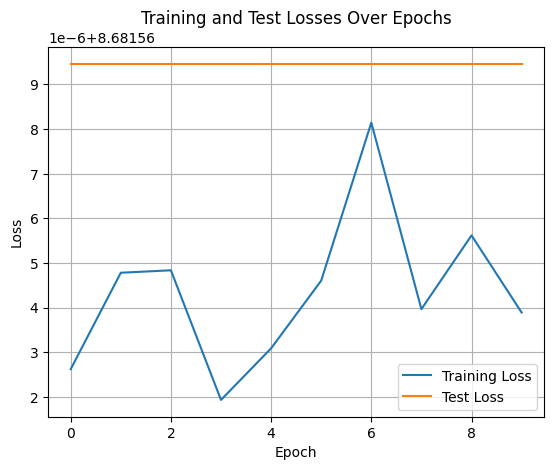

In [63]:
plt.plot(range(n_epochs), train_losses_, label="Training Loss")
plt.plot(range(n_epochs), valid_losses_, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Losses Over Epochs")
plt.grid()
plt.show()

Based on this result, we can conclude that Model2 is very poor. Compared to model1, it had a reduced dimension size thus resulting to a reduced number of parameters.

['<sos>', 'shopping', 'shines', 'beating', 'lying', 'kwon', 'representing', 'marshal', 'caucasian', 'cigarette', 'prepares', 'railing', 'gravel', 'when', 'muzzle', 'head', 'saxophone', 'drink', 'picture', 'patio', 'scout', 'motor', 'choir', 'nails', 'spins', 'waist', 'blankly', 'grimacing', 'words', 'system', 'horses', 'attempts', 'blinds', 'products', 'dappled', 'peep', 'clutching', 'addressing', 'artistic', 'skyscraper', 'trying', 'peer', 'road', 'maneuver', '80', '1', 'female', 'autumn', 'offer', 'deli', 'puppies', 'to', 'windowsill', 'yoga', 'belongings', 'joking', 'buffalo', 'penguin', 'frown', 'straining', 'finishes', 'waving', 'colored', 'multitasking', 'arrival', 'align', 'dad', 'region', 'idle', 'chained', 'wrestlers', 'jack', 'islamic', 'softly', 'pomeranian', 'starting', 'irish', 'gathering', 'determined', 'suds', 'decorations', 'badge', 'sews', 'zigzag', 'number', 'cane', 'tracks', 'party', 'metalworking', 'kayak', 'juice', 'packing', 'focused', 'symphony', 'nature', 'flopp

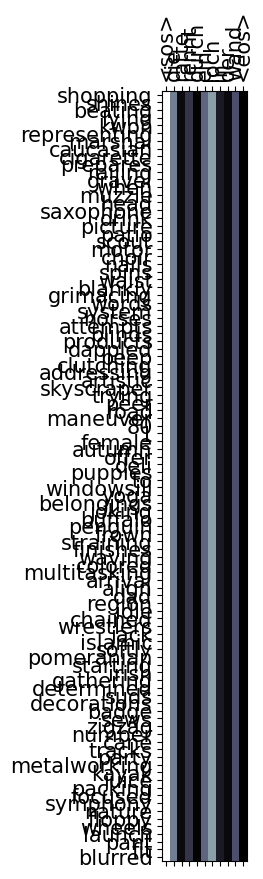

In [64]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model2,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation) #The rat ran through a hole in the wall
plot_attention(sentence_tokens, translation, attention)

 10%|█         | 1/10 [01:35<14:17, 95.26s/it]

	Train Loss:   0.876 | Train PPL:   2.401
	Valid Loss:   3.910 | Valid PPL:  49.894


 20%|██        | 2/10 [03:08<12:34, 94.36s/it]

	Train Loss:   0.836 | Train PPL:   2.308
	Valid Loss:   3.915 | Valid PPL:  50.134


 30%|███       | 3/10 [04:42<10:57, 93.97s/it]

	Train Loss:   0.773 | Train PPL:   2.166
	Valid Loss:   3.974 | Valid PPL:  53.207


 40%|████      | 4/10 [06:17<09:26, 94.42s/it]

	Train Loss:   0.727 | Train PPL:   2.068
	Valid Loss:   4.097 | Valid PPL:  60.151


 50%|█████     | 5/10 [07:52<07:52, 94.49s/it]

	Train Loss:   0.689 | Train PPL:   1.992
	Valid Loss:   4.183 | Valid PPL:  65.592


 60%|██████    | 6/10 [09:26<06:17, 94.37s/it]

	Train Loss:   0.642 | Train PPL:   1.901
	Valid Loss:   4.254 | Valid PPL:  70.388


 70%|███████   | 7/10 [11:00<04:43, 94.38s/it]

	Train Loss:   0.599 | Train PPL:   1.821
	Valid Loss:   4.290 | Valid PPL:  72.980


 80%|████████  | 8/10 [12:35<03:09, 94.53s/it]

	Train Loss:   0.559 | Train PPL:   1.749
	Valid Loss:   4.353 | Valid PPL:  77.729


 90%|█████████ | 9/10 [14:10<01:34, 94.60s/it]

	Train Loss:   0.541 | Train PPL:   1.717
	Valid Loss:   4.355 | Valid PPL:  77.882


100%|██████████| 10/10 [15:44<00:00, 94.45s/it]

	Train Loss:   0.512 | Train PPL:   1.669
	Valid Loss:   4.551 | Valid PPL:  94.682


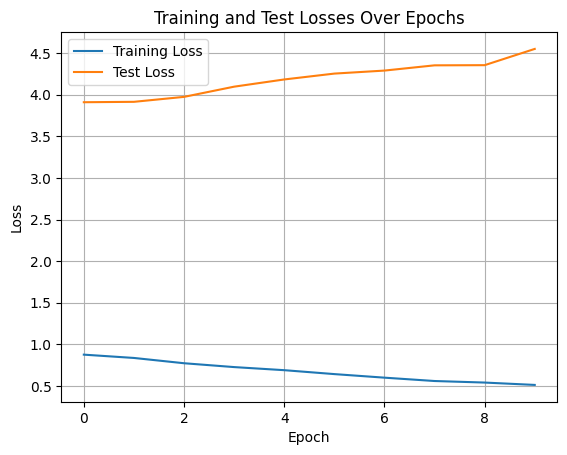

In [67]:
optimzer = optim.SGD(model2.parameters(), lr=0.001)
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
train_losses = []  # List to store training losses for each epoch
valid_losses = []  # List to store validation losses for each epoch
best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    # Get the training loss for the current epoch
    epoch_train_loss = train_fn(
        model1,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    train_losses.append(epoch_train_loss)  # Append current epoch's train loss to the list

    # Get the validation loss for the current epoch
    epoch_valid_loss = evaluate_fn(
        model1,
        valid_data_loader,
        criterion,
        device,
    )
    valid_losses.append(epoch_valid_loss)  # Append current epoch's valid loss to the list

    # Check if the validation loss is the best we've seen so far
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model1.state_dict(), "tut3-model1.pt")

    # Print the training and validation losses for the current epoch
    print(f"\tTrain Loss: {epoch_train_loss:7.3f} | Train PPL: {np.exp(epoch_train_loss):7.3f}")
    print(f"\tValid Loss: {epoch_valid_loss:7.3f} | Valid PPL: {np.exp(epoch_valid_loss):7.3f}")



# Plot both training and test losses
plt.plot(range(n_epochs), train_losses, label="Training Loss")
plt.plot(range(n_epochs), valid_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Losses Over Epochs")
plt.grid()
plt.show()




['<sos>', 'the', '<unk>', 'is', 'through', 'a', 'hole', 'in', 'the', 'wall', '.', '<eos>']


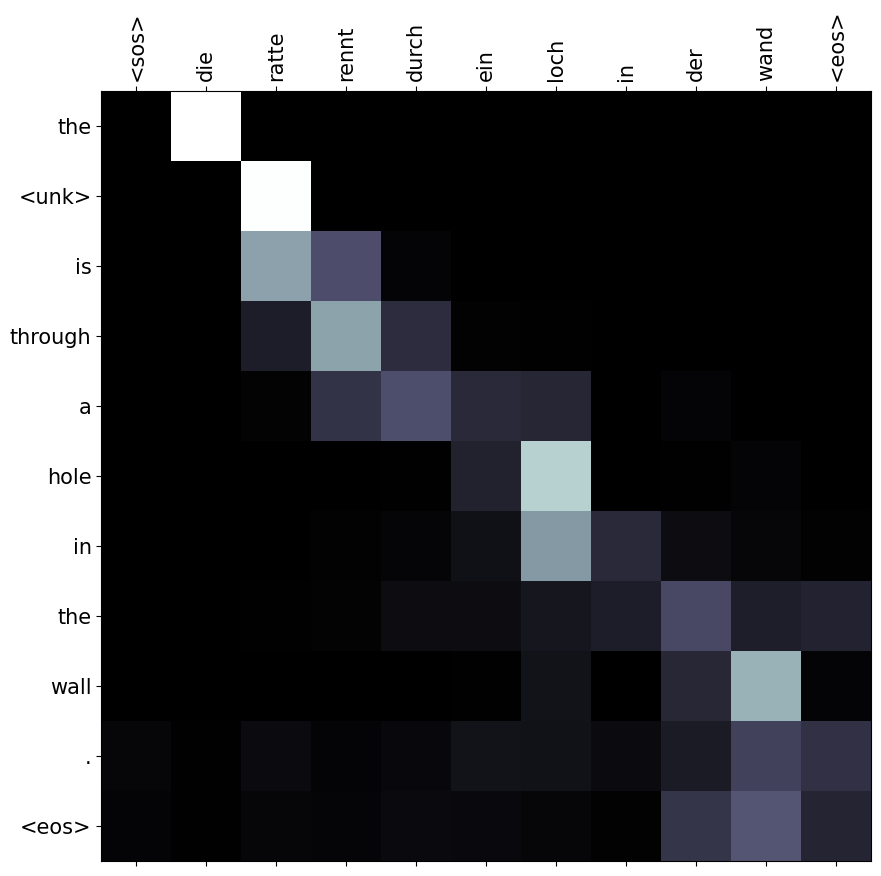

In [68]:

sentence = "Die Ratte rennt durch ein Loch in der Wand"

translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model1,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation) #The rat run through a hole in the wall
plot_attention(sentence_tokens, translation, attention)


Based on the experiments above,SGD performs better at the translation of the example sentence. It also uses model1 for thr translation task

['<sos>', 'shopping', 'shines', 'beating', 'lying', 'kwon', 'representing', 'marshal', 'caucasian', 'cigarette', 'prepares', 'railing', 'gravel', 'when', 'muzzle', 'head', 'saxophone', 'drink', 'picture', 'patio', 'scout', 'motor', 'choir', 'nails', 'spins', 'waist', 'blankly', 'grimacing', 'words', 'system', 'horses', 'attempts', 'blinds', 'products', 'dappled', 'peep', 'clutching', 'addressing', 'artistic', 'skyscraper', 'trying', 'peer', 'road', 'maneuver', '80', '1', 'female', 'autumn', 'offer', 'deli', 'puppies', 'to', 'windowsill', 'yoga', 'belongings', 'joking', 'buffalo', 'penguin', 'frown', 'straining', 'finishes', 'waving', 'colored', 'multitasking', 'arrival', 'align', 'dad', 'region', 'idle', 'chained', 'wrestlers', 'jack', 'islamic', 'softly', 'pomeranian', 'starting', 'irish', 'gathering', 'determined', 'suds', 'decorations', 'badge', 'sews', 'zigzag', 'number', 'cane', 'tracks', 'party', 'metalworking', 'kayak', 'juice', 'packing', 'focused', 'symphony', 'nature', 'flopp

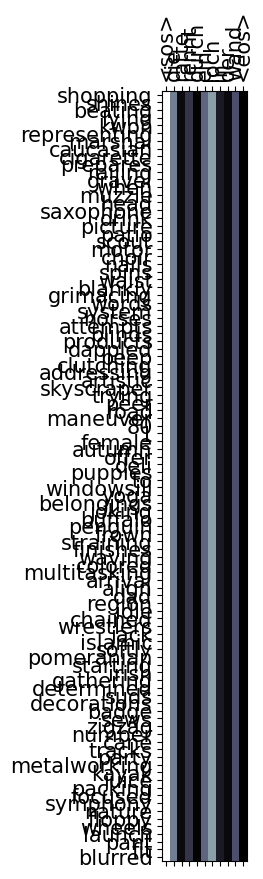

In [69]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model2,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation) #The rat ran through a hole in the wall
plot_attention(sentence_tokens, translation, attention)

As anticipated, it performs very poor when using model2.



**Part 1.**

**Advantages of using a Transformer for machine translation tasks**


1. It handles long-range dependencies in text.
2. Faster training due to parallelization capabilities as it avoids recursion (commonn in RNNs). Sentences are processed as a whole rather than word by word.


**The Role of Attention in the translation process** is to compute the similarity scores between words in a sentence. It enables the model to understand nuances and ambiguities in language.

**Attention mechanism** relieves input encodings including all information and delegates part of knowledge discovery to the final decision making/decoding layer.


**Part 2.**

**Most important network components/hyperparameters** especially for this specific task was the following
1. Batch size
2. Number of Epochs
3. Learning rate
4. Optimization Algorithm




The number of trainable parameters is directly proportional to the dimensions of the encoders, decoders, and hidden layers. This also impacts both the training and processing speeds. From my point of view, The trade-off depends on the task at hand. For short text, I recommend lesser number of encoder, hidden, and decoder layers.

Also, the device type for the implementation of the particular task matters as well.
